# RL Lab Assignment - 4

### CS22B1093 Rohan G

----------------------

#### Importing Necessary Libraries

In [59]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
from collections import defaultdict
from tqdm import tqdm
import random


#### Frozen Lake

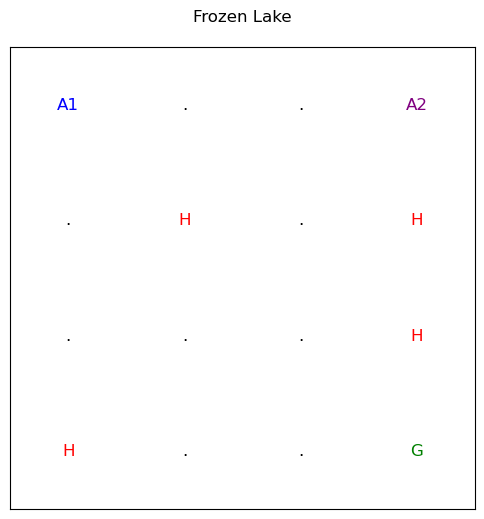

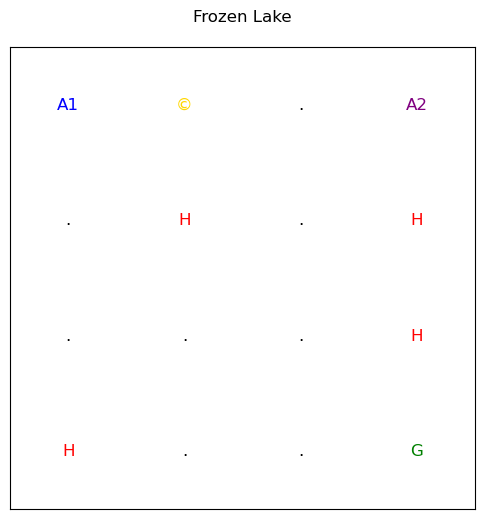

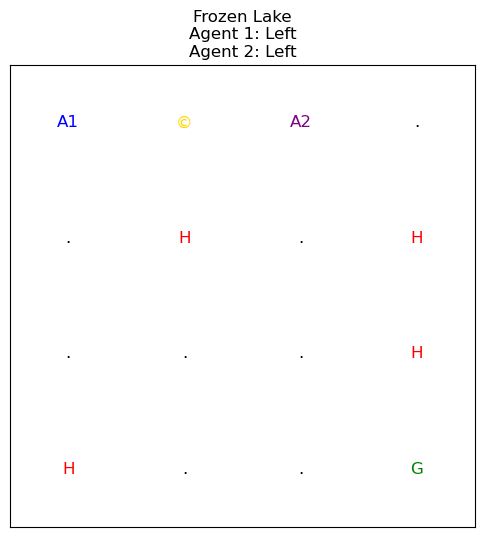

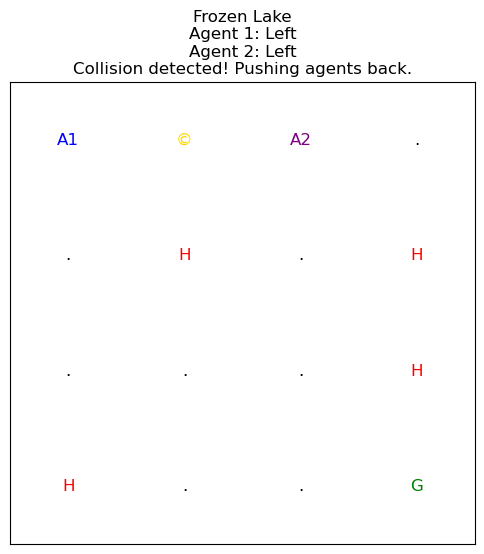

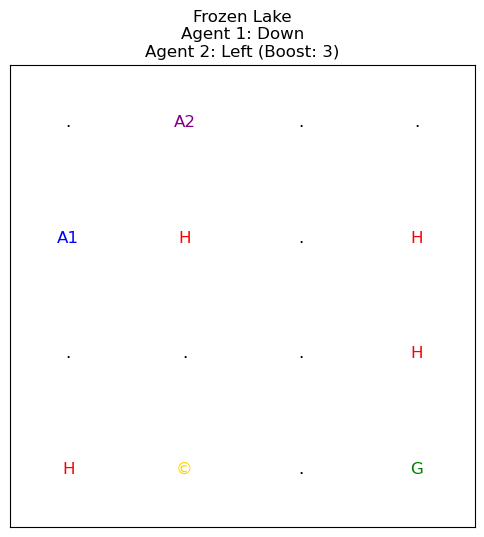

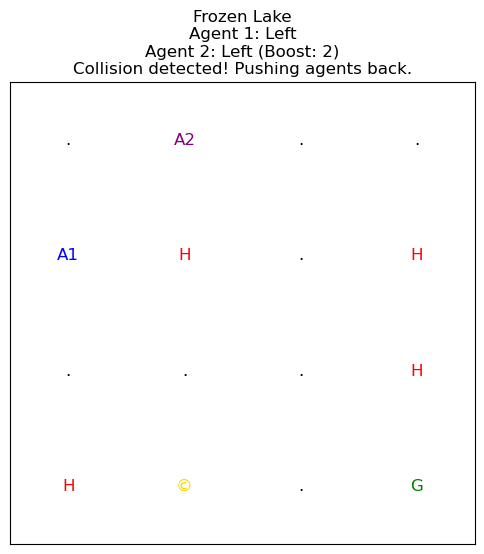

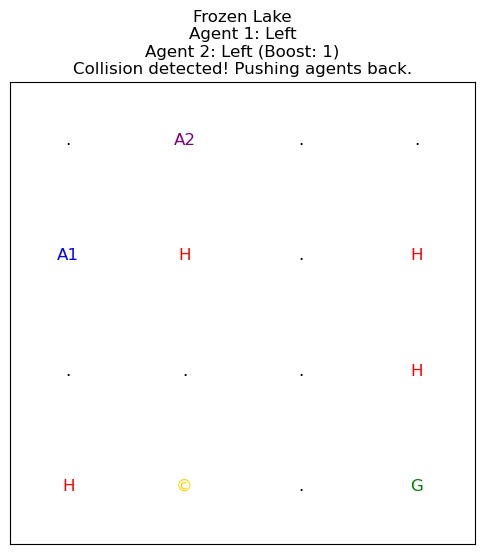

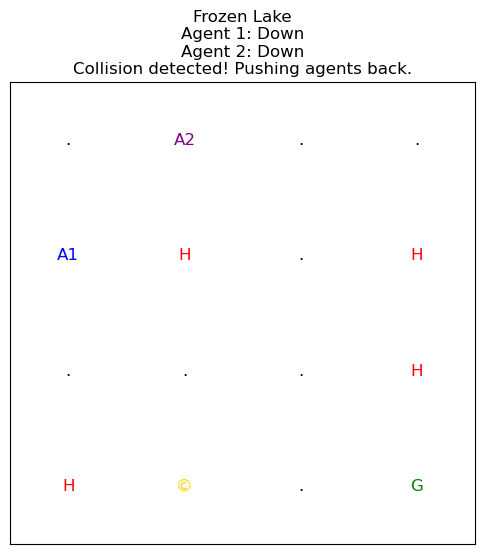

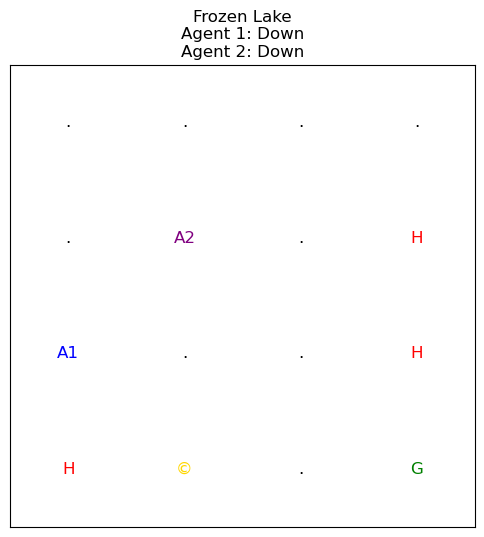

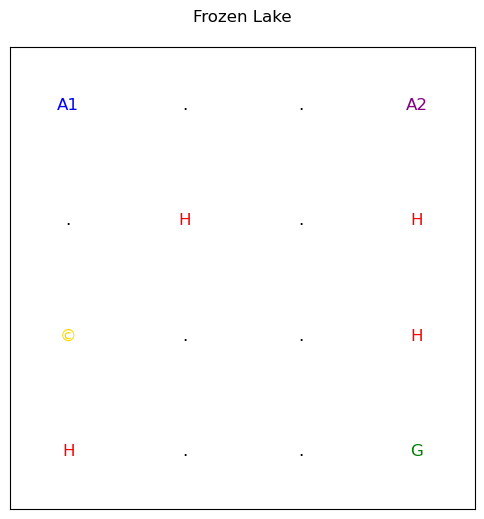

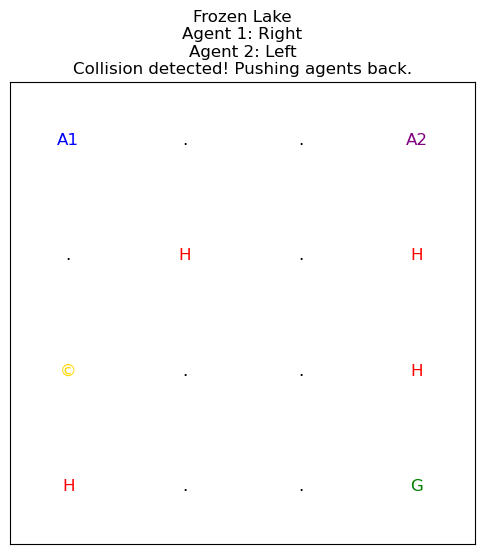

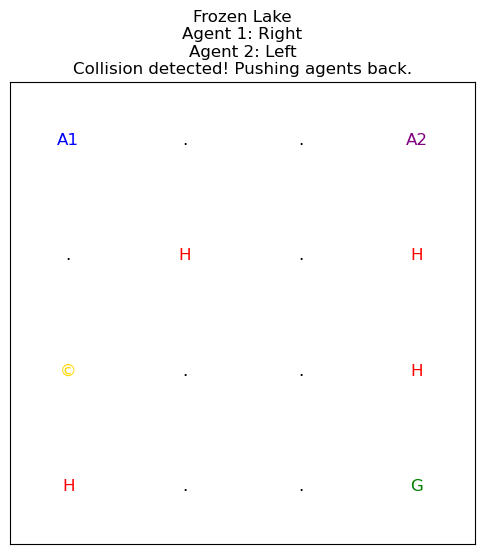

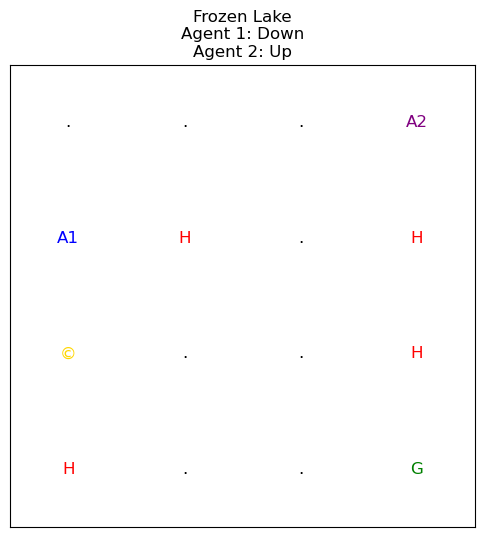

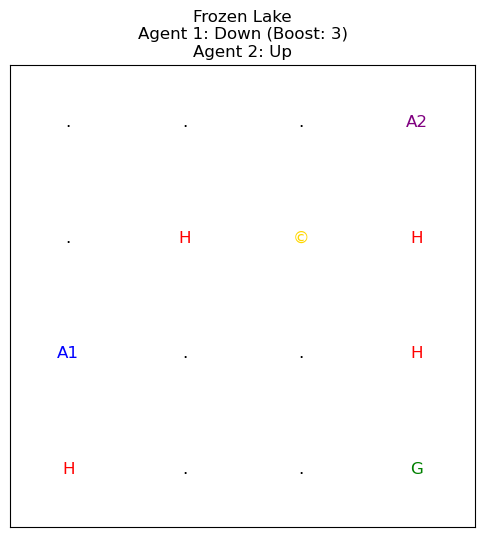

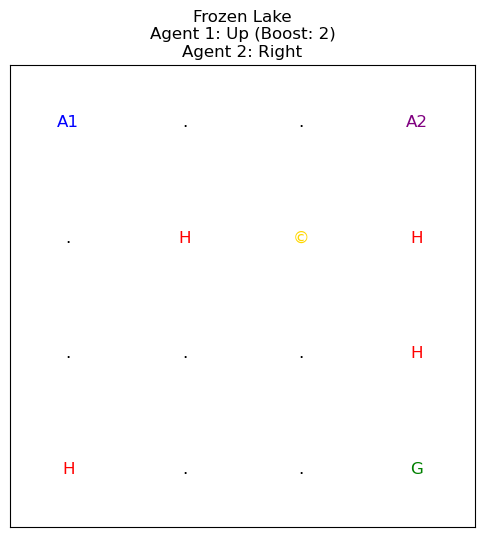

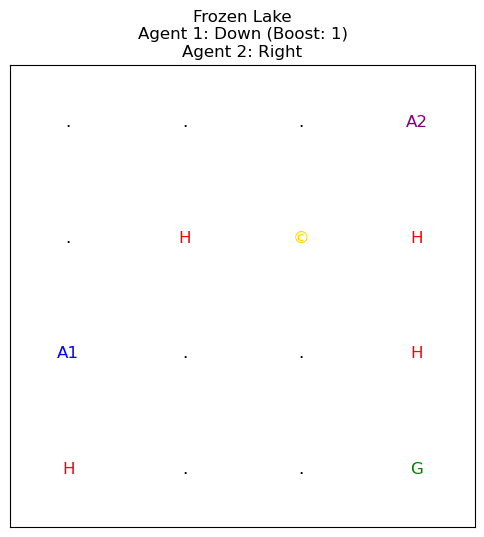

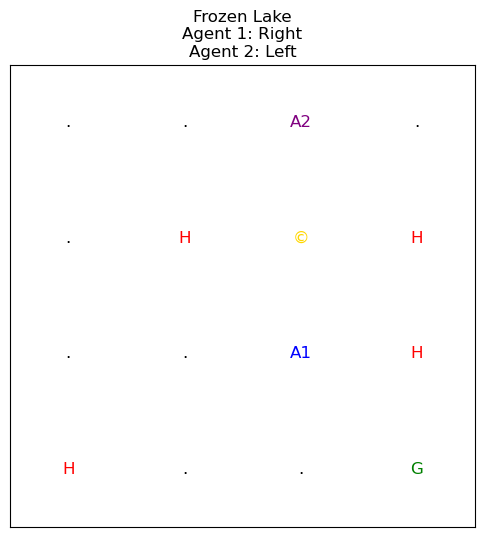

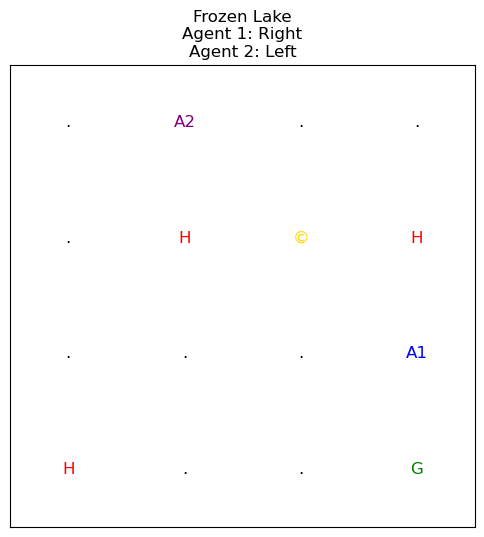

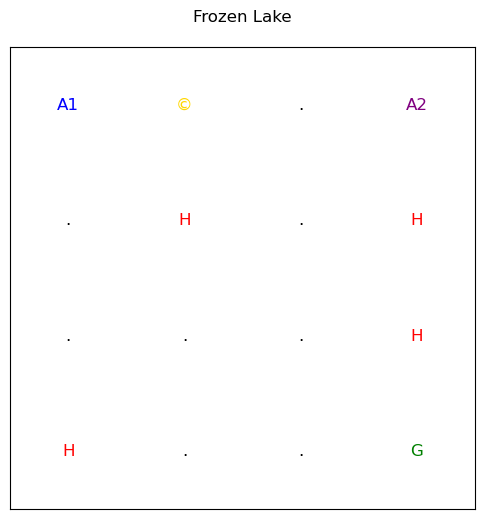

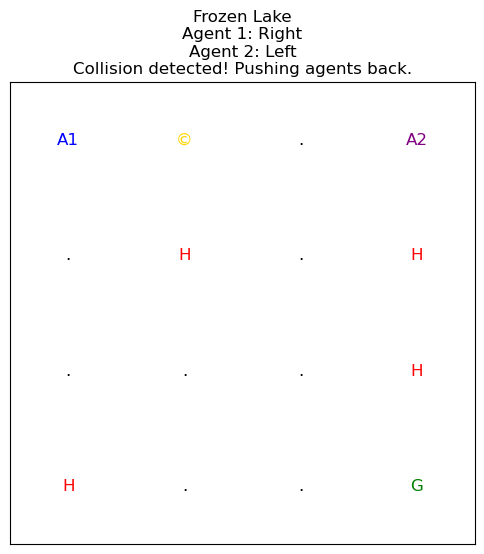

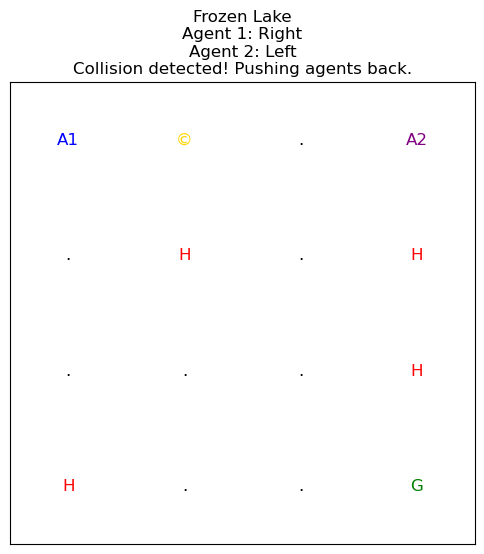

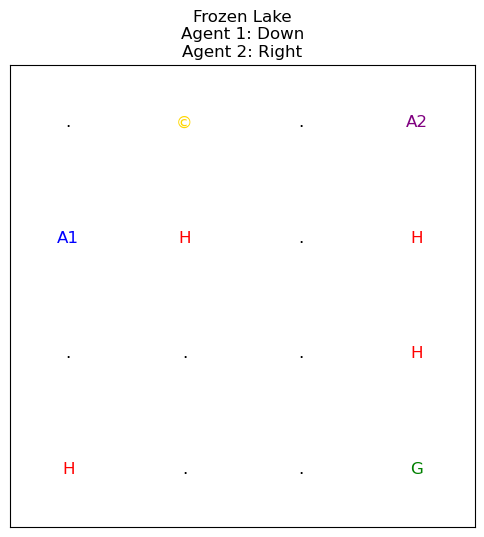

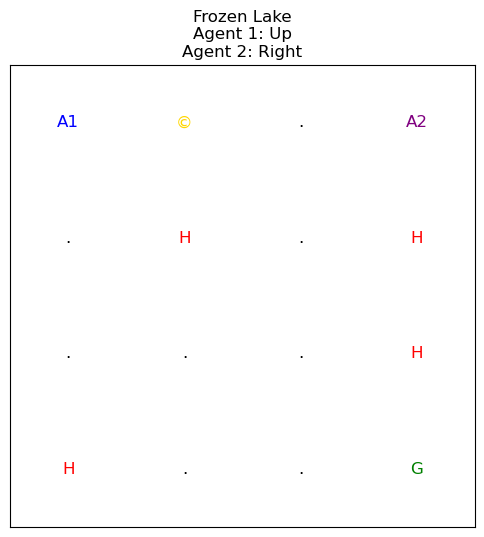

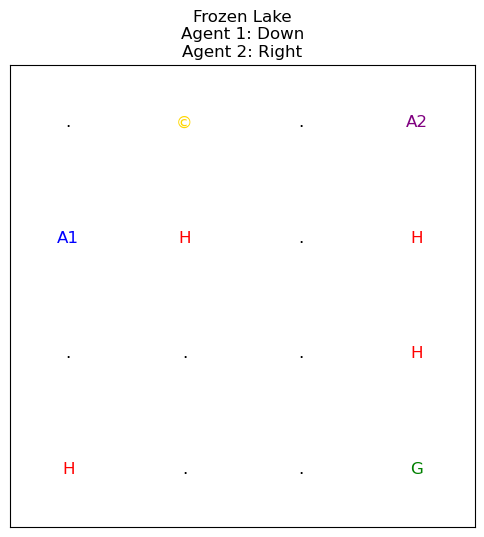

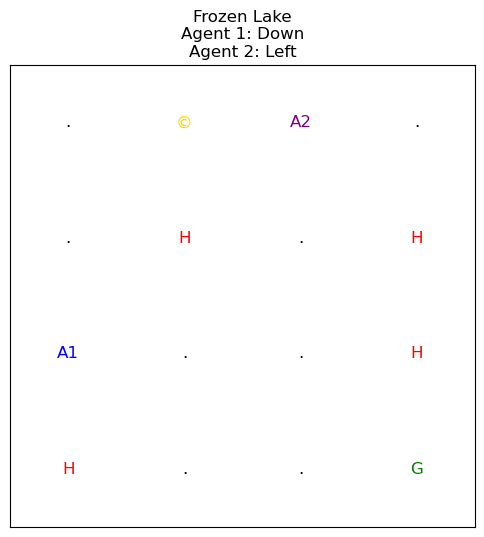

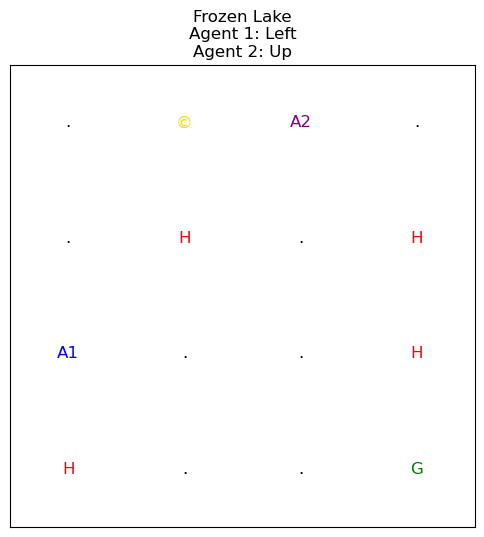

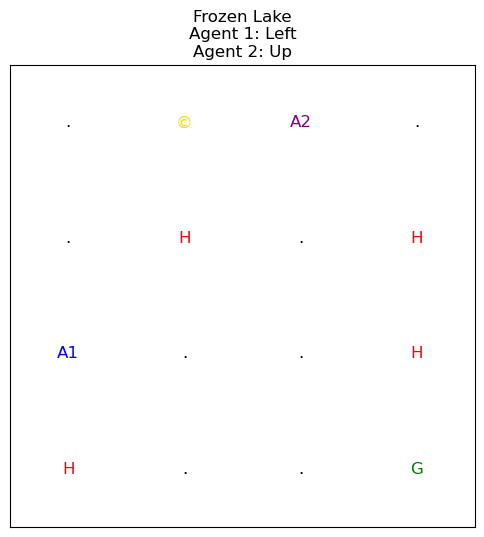

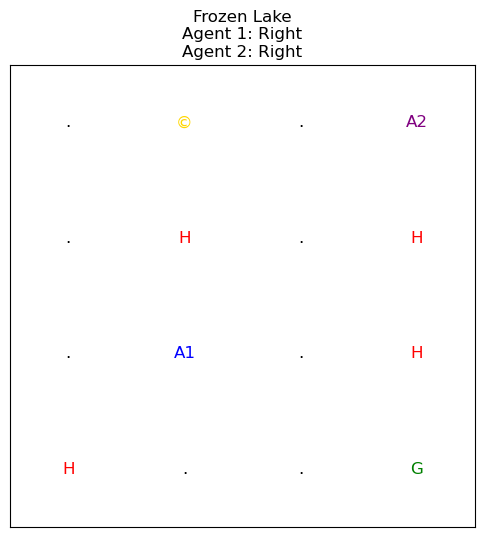

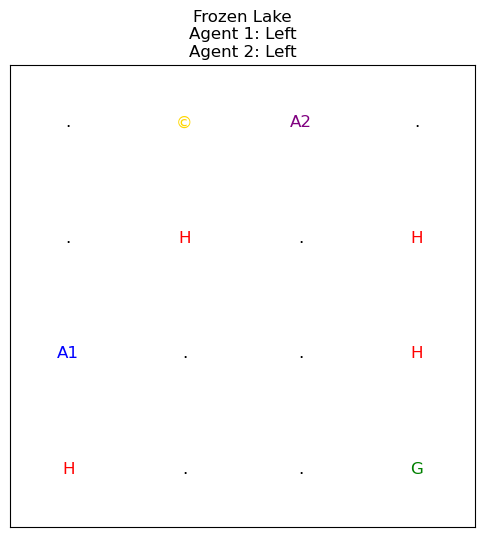

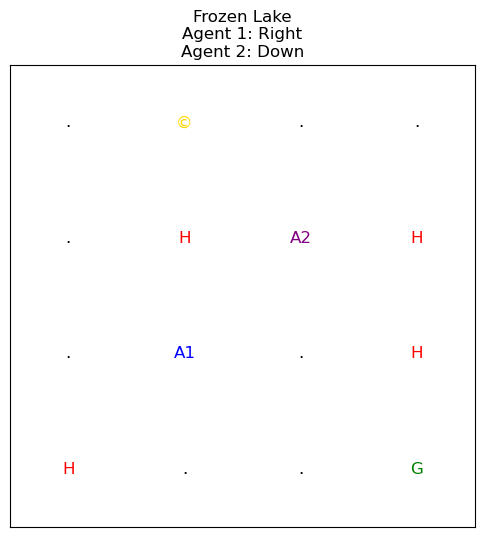

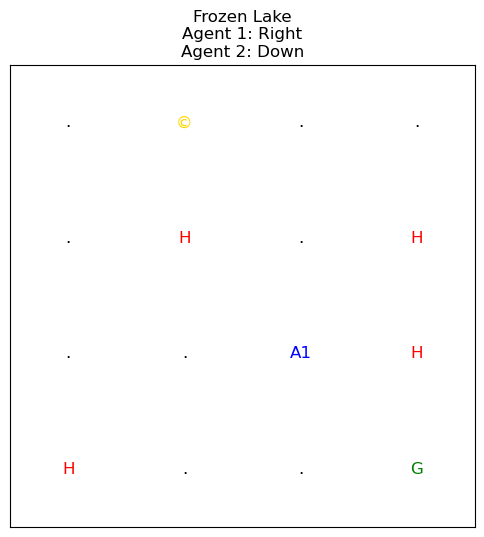

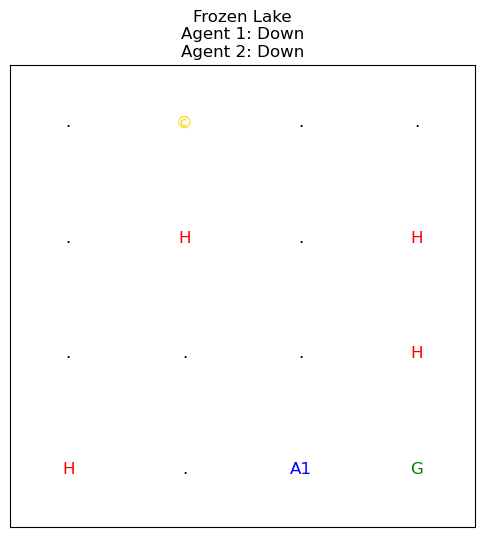

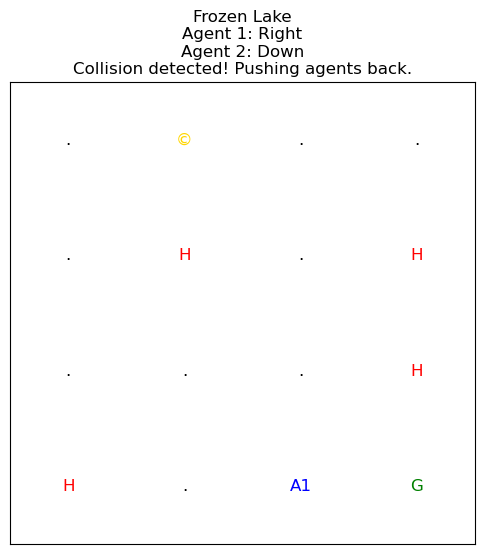

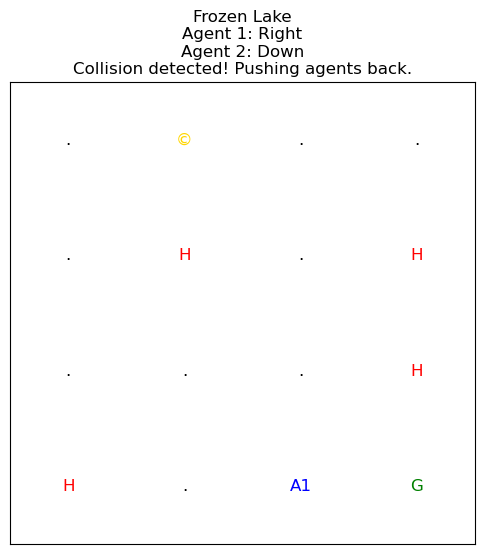

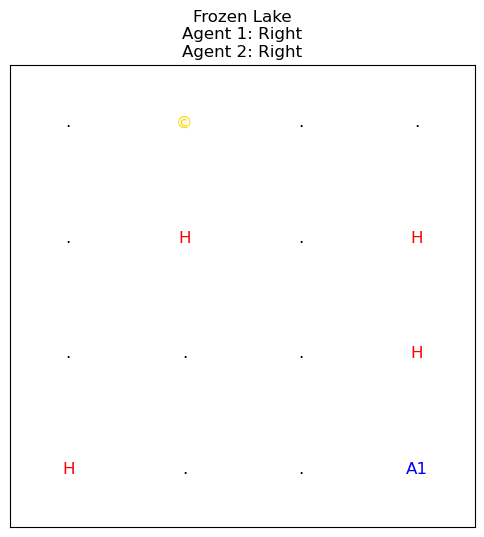

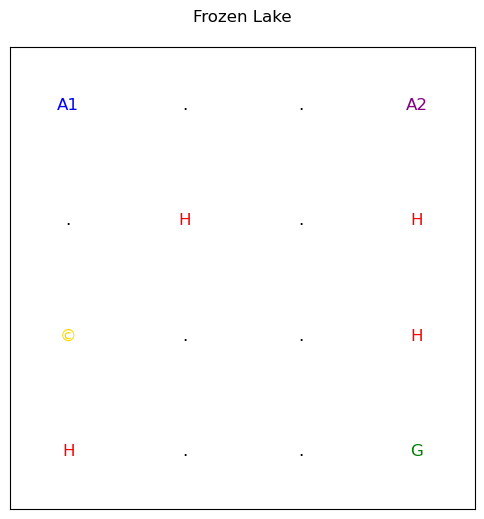

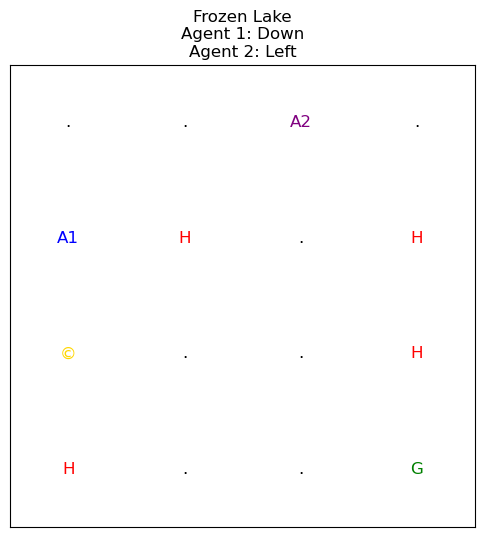

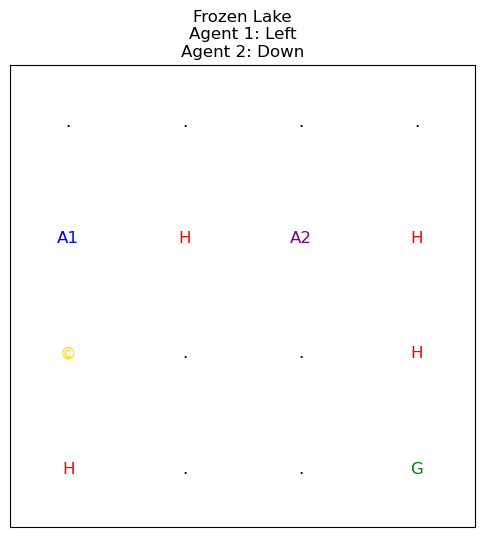

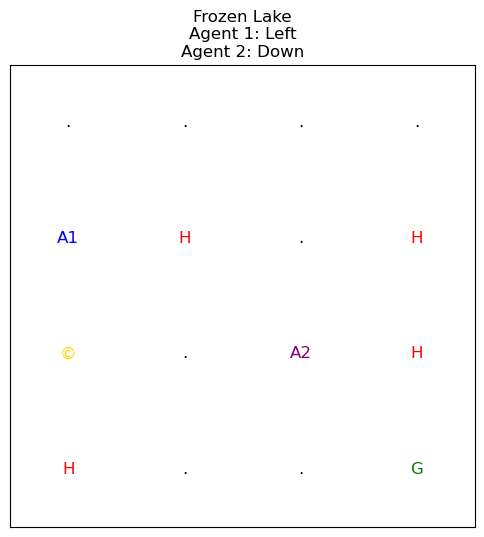

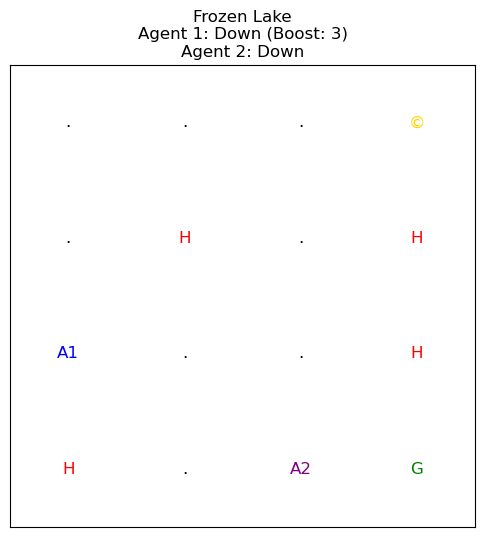

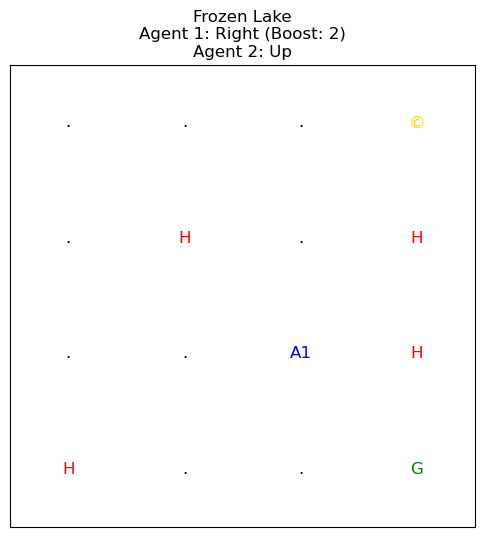

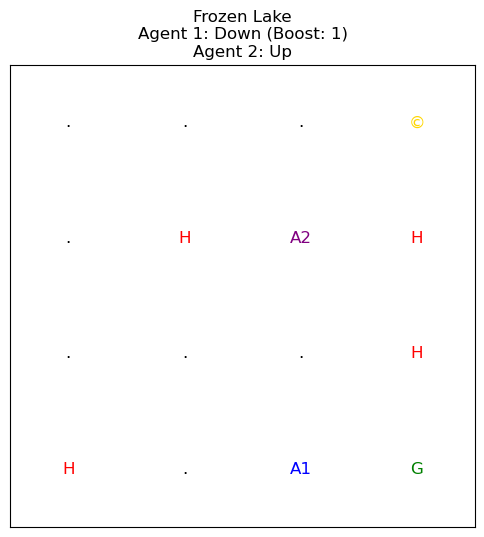

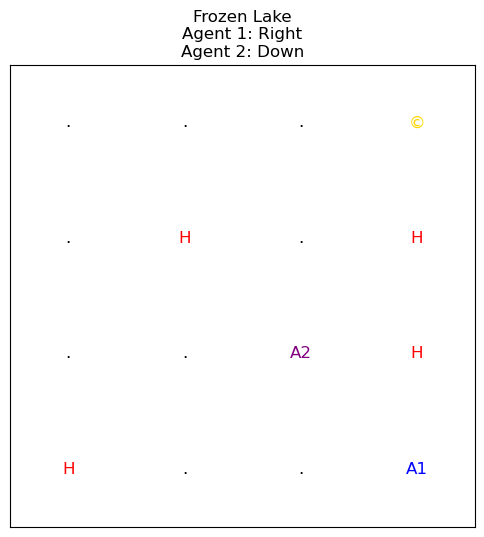

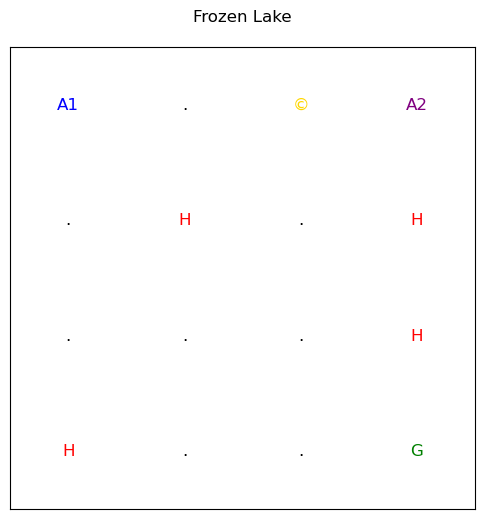

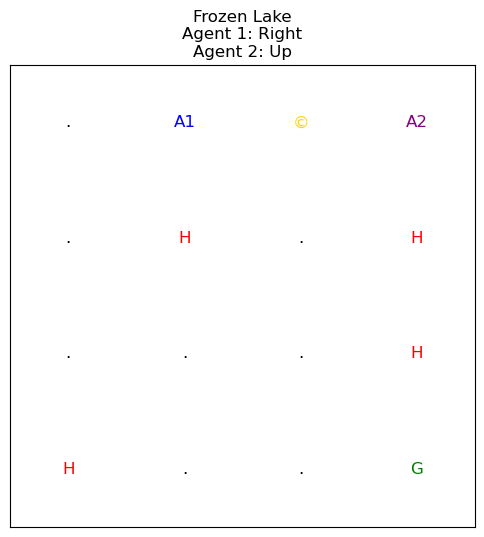

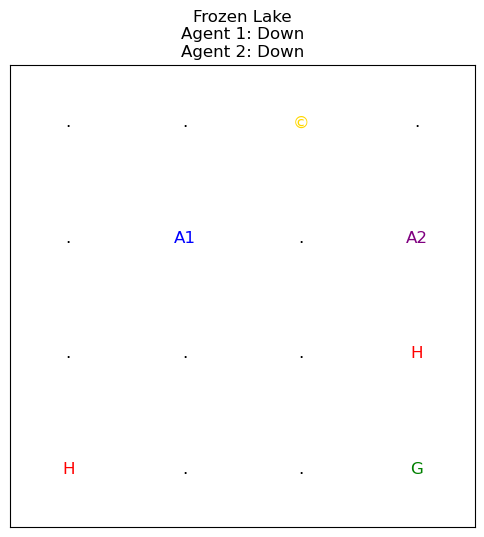


=== Final Q-table for Q-learning Agent ===
[[-3.39010115 -3.23443951 -2.83335957 -3.33128531]
 [-1.83300068 -2.04755    -1.82036992 -1.7523257 ]
 [-0.88578687 -0.83680985 -0.884905   -0.96606726]
 [-0.61996104 -0.5        -0.57106488 -0.49203434]
 [-2.56506019 -2.35277376 -2.52205422 -2.57536381]
 [ 0.          0.          0.          0.        ]
 [-0.59        0.18976387 -0.5        -0.29136948]
 [ 0.          0.          0.          0.        ]
 [-1.72136221 -1.7195     -0.84218447 -1.70795273]
 [-0.50467525  1.38039672 -0.40842397 -0.5       ]
 [-0.19        2.88755169 -0.5        -0.1999    ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.5        -0.19        4.40666216 -0.1099    ]
 [-0.1        -0.19        8.27972251  0.        ]
 [ 0.          0.          0.          0.        ]]

=== Final Q-table for SARSA Agent ===
[[-0.87945689 -0.72820782 -0.87766727 -0.77599447]
 [-1.31901845 -1.78511    -1.37179077 -1.37225527

In [60]:
class CustomFrozenLakeEnv(Env):
    def __init__(self, grid_size=4):
        super(CustomFrozenLakeEnv, self).__init__()

        self.grid_size = grid_size
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(grid_size * grid_size)

        self.lake = np.zeros((grid_size, grid_size), dtype=int)
        self.lake[-1, -1] = 2  # Goal
        self.lake[1, 1] = 1  # Hole
        self.lake[1, 3] = 1  # Hole
        self.lake[2, 3] = 1  # Hole
        self.lake[3, 0] = 1  # Hole

        self.rewards = np.zeros_like(self.lake, dtype=float)
        self.rewards[-1, -1] = 10.0  # Reward for reaching the goal
        self.rewards[self.lake == 1] = -5.0  # Penalty for falling into a hole
        self.rewards[self.lake == 0] = -1.0  # Step penalty

        self.state_agent1 = (0, 0)
        self.state_agent2 = (0, grid_size - 1)

        self.coin_position = self._place_coin()
        self.speed_boost_agent1 = 0  # Remaining speed boost steps for Agent 1
        self.speed_boost_agent2 = 0  # Remaining speed boost steps for Agent 2
        
        self.action_names = {
            0: "Left",
            1: "Down",
            2: "Right",
            3: "Up"
        }

        self.current_action1 = None
        self.current_action2 = None
        self.collision = False

    def _place_coin(self):
        """Randomly place a coin on the grid."""
        while True:
            x = random.randint(0, self.grid_size - 1)
            y = random.randint(0, self.grid_size - 1)
            if self.lake[x, y] == 0:
                return (x, y)

    def step(self, action_agent1, action_agent2):
        self.current_action1 = action_agent1
        self.current_action2 = action_agent2

        new_state_agent1 = self._move_agent(self.state_agent1, action_agent1, self.speed_boost_agent1)
        new_state_agent2 = self._move_agent(self.state_agent2, action_agent2, self.speed_boost_agent2)

        if self._are_adjacent(new_state_agent1, new_state_agent2):
            new_state_agent1 = self._push_back(self.state_agent1, new_state_agent1)
            new_state_agent2 = self._push_back(self.state_agent2, new_state_agent2)

        self.state_agent1 = new_state_agent1
        self.state_agent2 = new_state_agent2

        if self.state_agent1 == self.coin_position:
            self.speed_boost_agent1 = 4  # Speed boost for 4 moves
            self.coin_position = self._place_coin()
        if self.state_agent2 == self.coin_position:
            self.speed_boost_agent2 = 4  # Speed boost for 4 moves
            self.coin_position = self._place_coin()

        # Decrement speed boost counters
        if self.speed_boost_agent1 > 0:
            self.speed_boost_agent1 -= 1
        if self.speed_boost_agent2 > 0:
            self.speed_boost_agent2 -= 1

        # Calculate rewards
        reward_agent1 = self.rewards[self.state_agent1[0], self.state_agent1[1]]
        reward_agent2 = self.rewards[self.state_agent2[0], self.state_agent2[1]]

        # Check termination
        done_agent1 = (self.lake[self.state_agent1[0], self.state_agent1[1]] == 2 or 
                       self.lake[self.state_agent1[0], self.state_agent1[1]] == 1)
        done_agent2 = (self.lake[self.state_agent2[0], self.state_agent2[1]] == 2 or 
                       self.lake[self.state_agent2[0], self.state_agent2[1]] == 1)

        return (self._get_state_index(self.state_agent1), self._get_state_index(self.state_agent2)), \
               (reward_agent1, reward_agent2), \
               (done_agent1, done_agent2), {}

    def _move_agent(self, state, action, speed_boost):
        """Move an agent based on the action and speed boost."""
        x, y = state
        if speed_boost > 0:
            # Take two steps if speed boost is active
            x, y = self._single_step(x, y, action)
            x, y = self._single_step(x, y, action)
        else:
            x, y = self._single_step(x, y, action)
        return (x, y)

    def _single_step(self, x, y, action):
        """Take a single step in the given direction."""
        if action == 0:  # Left
            y = max(0, y - 1)
        elif action == 1:  # Down
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # Right
            y = min(self.grid_size - 1, y + 1)
        elif action == 3:  # Up
            x = max(0, x - 1)
        return x, y

    def _are_adjacent(self, state1, state2):
        """Check if two states are adjacent."""
        return abs(state1[0] - state2[0]) + abs(state1[1] - state2[1]) == 1

    def _push_back(self, old_state, new_state):
        """Push an agent back to its old state."""
        self.collision = True
        return old_state

    def reset(self):
        """Reset the environment."""
        self.state_agent1 = (0, 0)
        self.state_agent2 = (0, self.grid_size - 1)
        self.coin_position = self._place_coin()
        self.speed_boost_agent1 = 0
        self.speed_boost_agent2 = 0
        self.current_action1 = None
        self.current_action2 = None
        self.collision = False
        return (self._get_state_index(self.state_agent1), 
                self._get_state_index(self.state_agent2))

    def _get_state_index(self, state):
        """Convert (x, y) state to a single index."""
        return state[0] * self.grid_size + state[1]

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks(np.arange(self.grid_size + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(self.grid_size + 1) - 0.5, minor=True)
        ax.grid(which="minor", color='black', linestyle='-', linewidth=2)
        ax.tick_params(which="both", bottom=False, left=False, 
                       labelbottom=False, labelleft=False)

        title = "Frozen Lake\n"
        if self.current_action1 is not None:
            title += f"Agent 1: {self.action_names[self.current_action1]}"
            if self.speed_boost_agent1 > 0:
                title += f" (Boost: {self.speed_boost_agent1})"
        if self.current_action2 is not None:
            title += f"\nAgent 2: {self.action_names[self.current_action2]}"
            if self.speed_boost_agent2 > 0:
                title += f" (Boost: {self.speed_boost_agent2})"
        if self.collision:
            title += "\nCollision detected! Pushing agents back."
            self.collision = False
        ax.set_title(title)

        for x in range(self.grid_size):
            for y in range(self.grid_size):
                cell_y = self.grid_size - 1 - x
                if (x, y) == self.state_agent1:
                    ax.text(y, cell_y, 'A1', ha='center', va='center', 
                            fontsize=12, color='blue')
                elif (x, y) == self.state_agent2:
                    ax.text(y, cell_y, 'A2', ha='center', va='center', 
                            fontsize=12, color='purple')
                elif self.lake[x, y] == 1:
                    ax.text(y, cell_y, 'H', ha='center', va='center', 
                            fontsize=12, color='red')
                elif self.lake[x, y] == 2:
                    ax.text(y, cell_y, 'G', ha='center', va='center', 
                            fontsize=12, color='green')
                elif (x, y) == self.coin_position:
                    ax.text(y, cell_y, '©', ha='center', va='center', 
                            fontsize=12, color='gold')
                else:
                    ax.text(y, cell_y, '.', ha='center', va='center', 
                            fontsize=12, color='black')

        plt.draw()
        plt.pause(0.1)
        plt.close()

class Qlearning:
    def __init__(self, env, alpha=0.1, gamma=0.99):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.grid_size = int(np.sqrt(env.observation_space.n))

    def policy(self, state):
        """Greedy policy based on the current Q-table."""
        return np.argmax(self.Q[state])

    def update(self, state, action, reward, next_state):
        """Update Q-table using Q-learning rule."""
        best_next_action = np.argmax(self.Q[next_state])
        td_target = reward + self.gamma * self.Q[next_state, best_next_action]
        td_error = td_target - self.Q[state, action]
        self.Q[state, action] += self.alpha * td_error

class SARSA:
    def __init__(self, env, alpha=0.1, gamma=0.99):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.grid_size = int(np.sqrt(env.observation_space.n))

    def policy(self, state, epsilon=0.25):
        """Epsilon-greedy policy."""
        if np.random.rand() < (1 - epsilon):
            return np.argmax(self.Q[state])
        else:
            return self.env.action_space.sample()

    def update(self, state, action, reward, next_state, next_action):
        """Update Q-table using SARSA rule."""
        td_target = reward + self.gamma * self.Q[next_state, next_action]
        td_error = td_target - self.Q[state, action]
        self.Q[state, action] += self.alpha * td_error

class MultiAgentLearningSystem:
    def __init__(self, env):
        self.env = env
        # Initialize both agents:
        self.q_learning_agent = Qlearning(env)  # Agent 1 (Q-learning)
        self.sarsa_agent = SARSA(env)           # Agent 2 (SARSA)
        
    def train(self, episodes, visualize_interval=100):
        for episode in range(episodes):
            # Reset environment and get initial states
            state1, state2 = self.env.reset()

            # Initial actions for each agent
            action1 = self.q_learning_agent.policy(state1)
            action2 = self.sarsa_agent.policy(state2, epsilon=0.25)

            done1, done2 = False, False

            # Optionally render at interval
            if episode % visualize_interval == 0:
                self.env.render()

            while not (done1 or done2):
                (next_state1, next_state2), (reward1, reward2), (done1, done2), _ = \
                    self.env.step(action1, action2)
                
                # Next actions based on the updated states
                next_action1 = self.q_learning_agent.policy(next_state1)
                next_action2 = self.sarsa_agent.policy(next_state2, epsilon=0.25)

                # Update Q-tables
                self.q_learning_agent.update(state1, action1, reward1, next_state1)
                self.sarsa_agent.update(state2, action2, reward2, next_state2, next_action2)

                state1, state2 = next_state1, next_state2
                action1, action2 = next_action1, next_action2

                # Render the environment periodically
                if episode % visualize_interval == 0:
                    self.env.render()
                    time.sleep(0.2)  # so you can see the updates more clearly
    
    def render_environment(self):
        self.env.render()

if __name__ == "__main__":
    # Create the environment
    env = CustomFrozenLakeEnv(grid_size=4)

    # Create the multi-agent system
    multi_agent_system = MultiAgentLearningSystem(env)

    # Optional: Render the initial environment state
    multi_agent_system.render_environment()

    # Train the agents
    total_episodes = 100
    multi_agent_system.train(episodes=total_episodes, visualize_interval=20)

    # After training completes, print final Q-tables
    print("\n=== Final Q-table for Q-learning Agent ===")
    print(multi_agent_system.q_learning_agent.Q)

    print("\n=== Final Q-table for SARSA Agent ===")
    print(multi_agent_system.sarsa_agent.Q)


------------